# Ouroboros: summary statistics

This notebook covers all the experiments performed for testing the Ouroboros framework for early identification of at-risk students

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pandas as pd
BASE_PATH = os.path.dirname(os.path.abspath('__file__'))

SELF_LEARNER_MODULE_PATH = os.path.abspath(os.path.join(BASE_PATH, os.path.pardir))
SELF_LEARNER_LIB_PATH = os.path.join(SELF_LEARNER_MODULE_PATH, 'selflearner')

os.chdir(SELF_LEARNER_LIB_PATH)
sys.path.append(SELF_LEARNER_MODULE_PATH)

DATA_PATH = os.path.join(SELF_LEARNER_LIB_PATH, 'data_load')
DATA_PATH = os.path.join(DATA_PATH, 'data')

DS_ASSESSMENTS = 'assessments'
DS_COURSES = 'courses'
DS_STUD_ASSESSMENTS = 'studentAssessment'
DS_STUD_INFO = 'studentInfo'
DS_STUD_REG = 'studentRegistration'
DS_STUD_VLE = 'studentVle'
DS_VLE = 'vle'


df_courses = pd.read_csv(os.path.join(DATA_PATH, DS_COURSES+'.csv'))
df_stud = pd.read_csv(os.path.join(DATA_PATH, DS_STUD_INFO+'.csv')).reset_index()
df_ass = pd.read_csv(os.path.join(DATA_PATH, DS_ASSESSMENTS+'.csv'))
df_stud_ass = pd.read_csv(os.path.join(DATA_PATH, DS_STUD_ASSESSMENTS+'.csv')).reset_index()
df_stud_reg = pd.read_csv(os.path.join(DATA_PATH, DS_STUD_REG+'.csv'))
df_stud_vle = pd.read_csv(os.path.join(DATA_PATH, DS_STUD_VLE+'.csv'))

print("length of assessments: ", len(df_ass))
print("length of courses: ", len(df_courses))
print("length of student assessments: ", len(df_stud_ass))
print("length of student info: ", len(df_stud))
print("length of student registration: ", len(df_stud_reg))
print("length of student VLE: ", len(df_stud_vle))


def percConvert(ser):
  return ser/float(ser[-1])

length of assessments:  206
length of courses:  22
length of student assessments:  173912
length of student info:  32593
length of student registration:  32593
length of student VLE:  10655280


In [2]:
df_ass = pd.read_csv(os.path.join(DATA_PATH, DS_ASSESSMENTS+'.csv'))
df_ass_sorted = df_ass.sort_values(['code_module', 'code_presentation', 'assessment_type', 'date'])
df_ass_sorted['assessment_seq'] = (
    df_ass_sorted
    .groupby(['code_module', 'code_presentation', 'assessment_type'], sort=False)
    .cumcount()
    + 1
)

def _make_assessment_name(row):
    typ = row['assessment_type']
    seq = int(row['assessment_seq'])
    if typ == 'Exam':
        return 'Exam' if seq == 1 else f'Exam {seq}'
    return f'{typ} {seq}'

if 'assessment_name' not in df_ass_sorted.columns:
    df_ass_sorted['assessment_name'] = df_ass_sorted.apply(_make_assessment_name, axis=1)

# Keep only columns needed downstream and preserve original column names
df_ass = df_ass_sorted.copy()
print(df_ass.assessment_type.value_counts())
print(df_ass.assessment_name.value_counts())
df_ass.head(3)


assessment_type
TMA     106
CMA      76
Exam     24
Name: count, dtype: int64
assessment_name
Exam      22
TMA 1     22
TMA 2     22
TMA 3     22
TMA 4     19
TMA 5     14
CMA 1     13
CMA 2     13
CMA 3     13
CMA 4     13
CMA 5     11
CMA 6      8
TMA 6      7
CMA 7      5
Exam 2     2
Name: count, dtype: int64


,code_module,code_presentation,id_assessment,assessment_type,date,weight,assessment_seq,assessment_name
5,AAA,2013J,1757,Exam,NaN,100.0,1,Exam
0,AAA,2013J,1752,TMA,19.0,10.0,1,TMA 1
1,AAA,2013J,1753,TMA,54.0,20.0,2,TMA 2


In [17]:
# Table 1 replication: P(F|F A1), P(F|NS A1), and counts
import pandas as pd

# 1) Build A1 per (module, presentation): earliest non-Exam assessment (more robust than fixed 'TMA 1')
ass = df_ass.copy().sort_values(['code_module','code_presentation','date'])
ass_non_exam = ass[ass['assessment_type'] != 'Exam']
ass_non_exam = ass_non_exam[ass_non_exam['assessment_name'] == 'TMA 1']
first_ass = ass_non_exam.groupby(['code_module','code_presentation'], as_index=False).first()[[
    'code_module','code_presentation','id_assessment','assessment_name','date'
]]

rows = []
for (mod, pres), df_mod in df_stud.groupby(['code_module','code_presentation']):
    a1 = first_ass[(first_ass['code_module']==mod) & (first_ass['code_presentation']==pres)]
    if a1.empty:
        continue
    id_a1 = int(a1.iloc[0]['id_assessment'])
    # Link A1 submissions
    a1_sub = df_stud_ass[df_stud_ass['id_assessment']==id_a1][['id_student','score']]
    df_mod2 = df_mod[['id_student','final_result']].merge(a1_sub, on='id_student', how='left')

    submitted = df_mod2['score'].notnull()
    failed_a1 = submitted & (df_mod2['score'] < 50)
    ns_a1 = ~submitted
    course_failed = df_mod2['final_result'].isin(['Fail','Withdrawn'])

    cnt_f_and_fa1_s = int((course_failed & failed_a1).sum())
    cnt_f_and_nsa1 = int((course_failed & ns_a1).sum())

    denom_fa1 = int(failed_a1.sum())
    denom_nsa1 = int(ns_a1.sum())
    p_f_given_fa1 = (course_failed & failed_a1).sum() / denom_fa1 if denom_fa1 > 0 else None
    p_f_given_nsa1 = (course_failed & ns_a1).sum() / denom_nsa1 if denom_nsa1 > 0 else None

    rows.append({
        'code_module': mod,
        'code_presentation': pres,
        'P(F|F A1)': p_f_given_fa1,
        'P(F|NS A1)': p_f_given_nsa1,
        'CNT(F∧F A1∧S)': cnt_f_and_fa1_s,
        'CNT(F∧NS A1)': cnt_f_and_nsa1,
    })

per_pres = pd.DataFrame(rows)

# 2) Aggregate by course (probabilities mean across presentations; counts sum)
by_course = per_pres.groupby('code_module', as_index=False).agg({
    'P(F|F A1)': 'mean',
    'P(F|NS A1)': 'mean',
    'CNT(F∧F A1∧S)': 'sum',
    'CNT(F∧NS A1)': 'sum',
})

# 3) Add AVG (prob means) and SUM (counts sums)
avg_row = {
    'code_module': 'AVG',
    'P(F|F A1)': by_course['P(F|F A1)'].mean(),
    'P(F|NS A1)': by_course['P(F|NS A1)'].mean(),
    'CNT(F∧F A1∧S)': None,
    'CNT(F∧NS A1)': None,
}
sum_row = {
    'code_module': 'SUM',
    'P(F|F A1)': None,
    'P(F|NS A1)': None,
    'CNT(F∧F A1∧S)': by_course['CNT(F∧F A1∧S)'].sum(),
    'CNT(F∧NS A1)': by_course['CNT(F∧NS A1)'].sum(),
}

result_table1 = pd.concat([by_course, pd.DataFrame([avg_row, sum_row])], ignore_index=True)
display(result_table1)


,code_module,P(F|F A1),P(F|NS A1),CNT(F∧F A1∧S),CNT(F∧NS A1)
0,AAA,0.617143,0.942143,23.0,50.0
1,BBB,0.676387,0.990451,434.0,1888.0
2,CCC,0.936905,0.825153,255.0,1710.0
3,DDD,0.895071,0.987576,431.0,1436.0
4,EEE,0.860000,0.993202,49.0,643.0
5,FFF,0.844673,0.993044,122.0,1527.0
6,GGG,0.536120,0.915654,78.0,453.0
7,AVG,0.766614,0.949603,NaN,NaN
8,SUM,NaN,NaN,1392.0,7707.0


## Basic dataset statistics

Number of students in the courses, number of passed/failed students and the pass rates.

In [4]:
df_ass.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,assessment_seq,assessment_name
5,AAA,2013J,1757,Exam,NaN,100.0,1,Exam
0,AAA,2013J,1752,TMA,19.0,10.0,1,TMA 1
1,AAA,2013J,1753,TMA,54.0,20.0,2,TMA 2
2,AAA,2013J,1754,TMA,117.0,20.0,3,TMA 3
3,AAA,2013J,1755,TMA,166.0,20.0,4,TMA 4


In [5]:
df_stud.final_result.value_counts(), df_stud.code_module.value_counts()

(final_result
 Pass           12361
 Withdrawn      10156
 Fail            7052
 Distinction     3024
 Name: count, dtype: int64,
 code_module
 BBB    7909
 FFF    7762
 DDD    6272
 CCC    4434
 EEE    2934
 GGG    2534
 AAA     748
 Name: count, dtype: int64)

In [6]:
df_stud[(df_stud['code_presentation'] == '2014J') & (df_stud['code_module'] == 'AAA')].final_result.value_counts()

final_result
Pass           229
Withdrawn       66
Fail            46
Distinction     24
Name: count, dtype: int64

In [7]:
# Count of students
df_course_stats = pd.DataFrame(df_stud.groupby(['code_module','code_presentation'], as_index=False).size(), columns=['student_count'])

# def result_to_pass_fail(row):
#     if row['final_result'] == 'Distinction':
#         return 'Pass'
#     if row['final_result'] == 'Pass':
#         return 'Pass'
#     return 'Fail'
# Pass rates
from data_load.features_utils import FeaturesMapping
# df_stud['passed'] = df_stud.apply(lambda row: FeaturesMapping.
df_stud['passed'] = df_stud.apply(lambda row: FeaturesMapping.result_to_pass_fail(row), axis=1)


counts = df_stud.groupby(['code_module','code_presentation','passed']).size().rename('count').reset_index()
df_passed_stat = counts.pivot(index=['code_module','code_presentation'], columns='passed', values='count').fillna(0).reset_index()
df_passed_stat.columns.name = None
# Ensure consistent order and integer dtype
if 'Fail' not in df_passed_stat.columns:
    df_passed_stat['Fail'] = 0
if 'Pass' not in df_passed_stat.columns:
    df_passed_stat['Pass'] = 0

# Rename to original expected names and compute metrics
df_passed_stat = df_passed_stat.rename(columns={'Fail': 'failed_count', 'Pass': 'passed_count'})
df_passed_stat['failed_count'] = df_passed_stat['failed_count'].astype(int)
df_passed_stat['passed_count'] = df_passed_stat['passed_count'].astype(int)
df_passed_stat['registered'] = (df_passed_stat['passed_count'] + df_passed_stat['failed_count'])
df_passed_stat['pass_rate'] = df_passed_stat['passed_count'] / df_passed_stat['registered']

print("Pass rates for 2014J presentation:")
display(df_passed_stat.loc[df_passed_stat['code_presentation'] == '2014J'])


Pass rates for 2014J presentation:


,code_module,code_presentation,failed_count,passed_count,registered,pass_rate
1,AAA,2014J,112,253,365,0.693151
5,BBB,2014J,1140,1152,2292,0.502618
7,CCC,2014J,1483,1015,2498,0.406325
11,DDD,2014J,1011,792,1803,0.439268
14,EEE,2014J,504,684,1188,0.575758
18,FFF,2014J,1248,1117,2365,0.472304
21,GGG,2014J,305,444,749,0.592790


### Assessment statistics

In [8]:
# Create assessment_name from assessment_type to match original logic expectations
# Sort ensures consistent sequencing per (module, presentation, type)
df_ass_sorted = df_ass.sort_values(['code_module', 'code_presentation', 'assessment_type', 'date'])
df_ass_sorted['assessment_seq'] = (
    df_ass_sorted
    .groupby(['code_module', 'code_presentation', 'assessment_type'], sort=False)
    .cumcount()
    + 1
)

def _make_assessment_name(row):
    typ = row['assessment_type']
    seq = int(row['assessment_seq'])
    if typ == 'Exam':
        return 'Exam' if seq == 1 else f'Exam {seq}'
    return f'{typ} {seq}'

if 'assessment_name' not in df_ass_sorted.columns:
    df_ass_sorted['assessment_name'] = df_ass_sorted.apply(_make_assessment_name, axis=1)

# Keep only columns needed downstream and preserve original column names
df_ass = df_ass_sorted.copy()
print(df_ass.assessment_type.value_counts())
df_ass.head(3)

assessment_type
TMA     106
CMA      76
Exam     24
Name: count, dtype: int64


,code_module,code_presentation,id_assessment,assessment_type,date,weight,assessment_seq,assessment_name
5,AAA,2013J,1757,Exam,NaN,100.0,1,Exam
0,AAA,2013J,1752,TMA,19.0,10.0,1,TMA 1
1,AAA,2013J,1753,TMA,54.0,20.0,2,TMA 2


In [9]:
assessment_name="TMA 1"

df_ass_sel = df_ass.loc[df_ass['assessment_name'] == assessment_name][['code_module','code_presentation','date','weight']]
df_ass_sel.sort_values('code_module')

,code_module,code_presentation,date,weight
0,AAA,2013J,19.0,10.0
6,AAA,2014J,19.0,10.0
17,BBB,2013B,19.0,5.0
29,BBB,2013J,19.0,5.0
41,BBB,2014B,12.0,5.0
48,BBB,2014J,19.0,0.0
58,CCC,2014B,32.0,9.0
68,CCC,2014J,32.0,9.0
102,DDD,2014J,20.0,5.0
95,DDD,2014B,25.0,10.0


It can be seen that there is little bit of correlation between the cutoff-date and the weight of the TMA, apart from one exception - here the cutoff is in date 60 with 0 importance, ,this is for GGG course.

### TMA1 probabilities of submission and the subsequent pass/fail in the module.

In [10]:
# TMA1 analysis
assessment_name = 'TMA 1'
df_tma1 = df_ass.loc[df_ass['assessment_name'] == assessment_name]

# Show selected assessments like original notebook
display(df_tma1[['code_module','code_presentation','date','weight']].sort_values('code_module'))

df_stud_tma1 = df_stud_ass.merge(
    right=df_tma1, 
    how='inner', 
    left_on='id_assessment', 
    right_on='id_assessment', 
    sort=False
)

# Aggregation
agg = df_stud_tma1.groupby(['code_module','code_presentation']).agg(
    count_submitted=('score', 'count'),
    avg_submitted=('score', 'mean'),
    sum=('score', 'sum')
).reset_index()

# Merge with pass stats and compute share
agg = agg.merge(
    right=df_passed_stat[['code_module','code_presentation','passed_count','failed_count','registered','pass_rate']], 
    on=['code_module', 'code_presentation'], 
    how='inner'
)
agg['submitted_tma1_pct'] = agg['count_submitted'] / agg['registered']

# Column order to match original display
ordered_cols = ['code_module','code_presentation','avg_submitted','sum','count_submitted','passed_count','failed_count','registered','pass_rate','submitted_tma1_pct']
df_tma1_stat = agg[ordered_cols]

print("TMA1 submission rates for 2014J:")
display(df_tma1_stat.loc[df_tma1_stat['code_presentation'] == '2014J'])


,code_module,code_presentation,date,weight
0,AAA,2013J,19.0,10.0
6,AAA,2014J,19.0,10.0
17,BBB,2013B,19.0,5.0
29,BBB,2013J,19.0,5.0
41,BBB,2014B,12.0,5.0
48,BBB,2014J,19.0,0.0
58,CCC,2014B,32.0,9.0
68,CCC,2014J,32.0,9.0
102,DDD,2014J,20.0,5.0
95,DDD,2014B,25.0,10.0


TMA1 submission rates for 2014J:


,code_module,code_presentation,avg_submitted,sum,count_submitted,passed_count,failed_count,registered,pass_rate,submitted_tma1_pct
1,AAA,2014J,69.255193,23339.0,337,253,112,365,0.693151,0.923288
5,BBB,2014J,58.866817,104312.0,1772,1152,1140,2292,0.502618,0.773124
7,CCC,2014J,78.790175,112276.0,1425,1015,1483,2498,0.406325,0.570456
11,DDD,2014J,72.288339,102288.0,1415,792,1011,1803,0.439268,0.784803
14,EEE,2014J,86.117330,80003.0,929,684,504,1188,0.575758,0.781987
18,FFF,2014J,78.598684,143364.0,1824,1117,1248,2365,0.472304,0.771247
21,GGG,2014J,66.599315,38894.0,584,444,305,749,0.592790,0.779706


In [11]:
# Process all assessments
df_stud_all_ass = df_stud.merge(right=df_ass, on=['code_module','code_presentation'], how='left')
df_stud_all_ass = df_stud_all_ass.merge(right=df_stud_ass, how='left', on=['id_student','id_assessment'], sort=False)
df_stud_all_ass['submitted'] = df_stud_all_ass['score'].notnull()
df_stud_all_ass['succeeded'] = df_stud_all_ass['score'] > 49

# Fixed: Filter out NULL assessment_name and remove duplicates
# 1. Remove records where assessment_name is NULL
df_stud_all_ass_filtered = df_stud_all_ass[df_stud_all_ass['assessment_name'].notnull()].copy()

# 2. Remove duplicates, prioritizing succeeded=True
df_stud_all_ass_clean = df_stud_all_ass_filtered.sort_values('succeeded', ascending=False).drop_duplicates(
    subset=['code_module', 'code_presentation', 'id_student', 'assessment_name'],
    keep='first'
)

# 3. Check for any remaining duplicates (for debugging)
duplicate_check = df_stud_all_ass_clean.duplicated(
    subset=['code_module', 'code_presentation', 'id_student', 'assessment_name'], 
    keep=False
)
if duplicate_check.any():
    print(f"Warning: Still found {duplicate_check.sum()} duplicate entries after cleaning")
    # Remove all duplicates as a last resort
    df_stud_all_ass_clean = df_stud_all_ass_clean[~duplicate_check]

# Create pivot table
pivoted = df_stud_all_ass_clean.set_index(['code_module', 'code_presentation', 'id_student','assessment_name'])[['succeeded']]
df_stud_tma_results = pivoted.unstack()

# Flatten columns to plain assessment names and sort like original
df_stud_tma_results.columns = [col[1] if isinstance(col, tuple) else col for col in df_stud_tma_results.columns]
# Stable assessment column ordering: CMA 1..7, Exam, Exam 2, TMA 1..6 if present
assessment_order = [
    "CMA 1","CMA 2","CMA 3","CMA 4","CMA 5","CMA 6","CMA 7",
    "Exam","Exam 2",
    "TMA 1","TMA 2","TMA 3","TMA 4","TMA 5","TMA 6"
]
existing_ass_cols = [c for c in assessment_order if c in df_stud_tma_results.columns]
# Keep assessment columns first, then reset index
df_stud_tma_results = df_stud_tma_results[existing_ass_cols]
df_stud_tma_results = df_stud_tma_results.reset_index()

# Merge student demographics
keep_cols = ['code_module', 'code_presentation','id_student','gender','region','highest_education','imd_band','age_band','num_of_prev_attempts','studied_credits','disability','final_result','passed']
df_stud_tma_results = df_stud_tma_results.merge(
    df_stud[keep_cols],
    on=['code_module', 'code_presentation','id_student'], 
    how='inner'
)

print(f"Found {len(existing_ass_cols)} assessment types")
print("Sample of student TMA results:")
display(df_stud_tma_results.head())


Found 15 assessment types
Sample of student TMA results:


,code_module,code_presentation,id_student,CMA 1,CMA 2,CMA 3,CMA 4,CMA 5,CMA 6,CMA 7,...,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,passed
0,AAA,2013J,11391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,Pass
1,AAA,2013J,28400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,Pass
2,AAA,2013J,30268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,Fail
3,AAA,2013J,31604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,Pass
4,AAA,2013J,32885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,Pass


In [12]:
def fail_if_tmafail(df):
    exams = ["CMA 1", "CMA 2","CMA 3", "CMA 4","CMA 5","CMA 6","CMA 7", "Exam","Exam 2","TMA 1","TMA 2","TMA 3","TMA 4","TMA 5","TMA 6"]
    allseries = pd.Series()
    lenexams = 0
    indexexams = []

    for exam in exams:
        if df[exam].notnull().all():
            s = pd.crosstab(df[exam], df['passed'], margins=True).apply(percConvert, axis=1)['Fail'][0:2]
            lenexams = lenexams + 1
            
            allseries = allseries.append(s)
            indexexams.append(exam)
            
    df_exam_pp = pd.DataFrame(allseries.reshape(lenexams,2), columns=["NS","S"], index=indexexams)
    return df_exam_pp

def tma_fail_pp(df, exam="TMA 1"):
    modules = df['code_module'].unique()
    presentations = df['code_presentation'].unique()
    allseries = pd.Series()
    indexes = []
    
    for module in modules:
        for pres in presentations:
            df_course = df.loc[(df['code_module'] == module) & (df['code_presentation'] == pres)]
            if(len(df_course) > 0 and df_course[exam].notnull().all()):
                s = pd.crosstab(df_course[exam], df_course['passed'], margins=True).apply(percConvert, axis=1)['Fail'][0:2]
                # allseries = allseries.append(s)
                allseries = pd.concat([allseries, s], ignore_index=True)
                indexes.append((module,pres))
            
    df_exam_pp = pd.DataFrame(allseries.values.reshape(len(indexes),2), columns=["NS","S"], index=pd.MultiIndex.from_tuples(indexes))
    return df_exam_pp

In [13]:
exam='TMA 1'
df=tma_fail_pp(df_stud_tma_results, exam=exam).reset_index()
df.columns = ['code_module','code_presentation','NS','S']
df_filtered = df_ass.loc[df_ass['assessment_name'] == exam][['code_module','code_presentation','date','weight']]
df_s_ns = df.merge(right=df_filtered, on=['code_module','code_presentation'])
df_s_ns_grouped = df_s_ns[['code_module','NS','S','date','weight']].groupby(['code_module'])
df_s_ns_grouped.mean()

/var/folders/zj/lqknstz16bd0c8jvpgd45_000000gn/T/ipykernel_21765/426161848.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return ser/float(ser[-1])
/var/folders/zj/lqknstz16bd0c8jvpgd45_000000gn/T/ipykernel_21765/1466642229.py:30: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  allseries = pd.concat([allseries, s], ignore_index=True)
/var/folders/zj/lqknstz16bd0c8jvpgd45_000000gn/T/ipykernel_21765/426161848.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

,NS,S,date,weight
code_module,,,,
AAA,0.800435,0.220036,19.00,10.000
BBB,0.880914,0.361313,17.25,3.750
CCC,0.838138,0.377094,32.00,9.000
DDD,0.965112,0.417039,23.75,8.125
EEE,0.980799,0.271695,33.00,16.000
FFF,0.980450,0.409291,21.50,12.500
GGG,0.829965,0.257326,61.00,0.000


### Does the weight of TMA1 influence the submission rate?

The question is to examine, whether some of the properties of the TMA1 has influence on the success, if the TMA was or was not submitted - e.g. $P(SUCCESS| TMA\_submitted,x)$ and $P(SUCCESS| TMA\_not\_submitted,x)$, given some property $x$ about the TMA.

<Axes: xlabel='weight', ylabel='NS'>

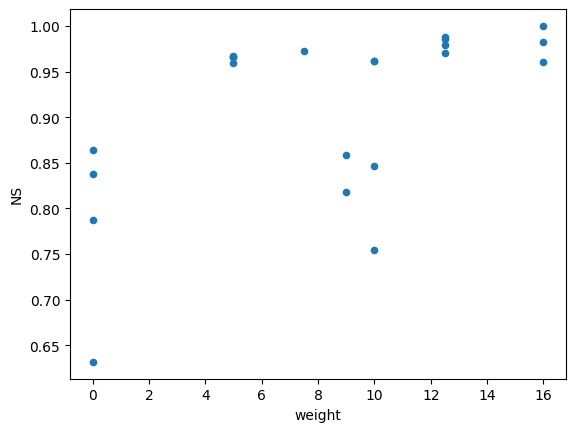

In [14]:
# Weight of the assessment:
df_s_ns.plot(kind='scatter', x='weight', y='NS')

## Student withdrawal 

When do students withdraw from the courses?

/var/folders/zj/lqknstz16bd0c8jvpgd45_000000gn/T/ipykernel_21765/2357650816.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(s_unregistered, norm_hist=False, kde=False)


<Axes: xlabel='date_unregistration'>

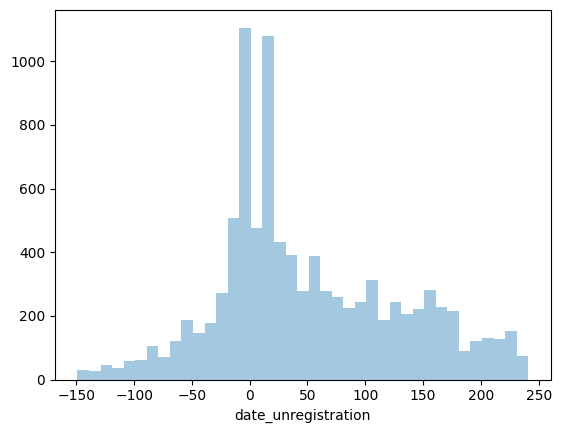

In [15]:
df_unregistered = df_stud_reg[df_stud_reg['date_unregistration'].notnull()].reset_index()
df_unregistered = df_unregistered[df_unregistered['date_unregistration'] > -150]
df_unregistered = df_unregistered[df_unregistered['date_unregistration'] <= 250]

# df_unregistered.groupby(by='date_unregistration').size().order()
df_unregistered = df_unregistered[df_unregistered['code_module'] != 'AAA']
# df_unregistered = df_unregistered[df_unregistered['code_presentation'] != '2013B']
df_unregistered = df_unregistered[df_unregistered['code_module'] != 'GGG']

s_unregistered = df_unregistered['date_unregistration']
sns.distplot(s_unregistered, norm_hist=False, kde=False)

The same distribution of date unregistration, but now per module/presentation.

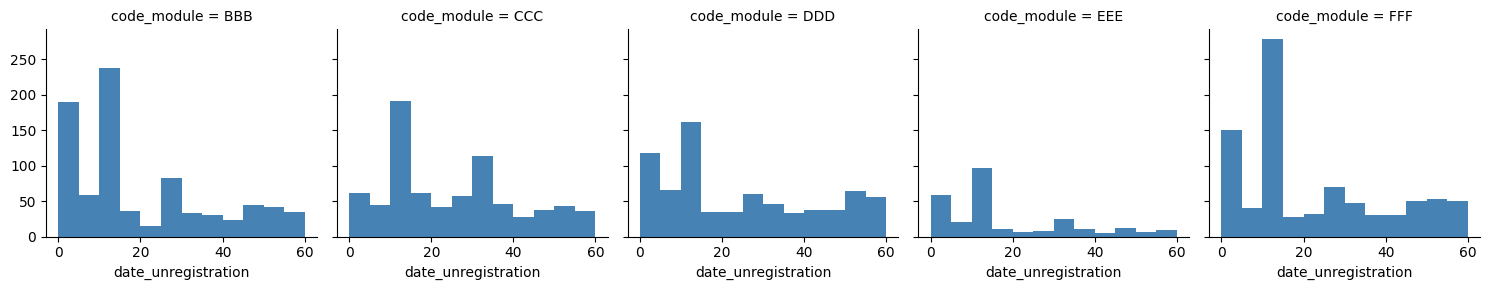

In [16]:
g = sns.FacetGrid(df_unregistered,col="code_module", margin_titles=True)
bins = np.linspace(0, 60, 13)
g.map(plt.hist, "date_unregistration", color="steelblue", bins=bins, lw=0)